# Домашнее задание № 1

### Выполнил Кузнецов С.И.

In [1]:
# Импортируем библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from datetime import datetime

In [2]:
# Импортируем исходный датафрейм
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [3]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [4]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [5]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [6]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  392963
Total transactions in test dataset:  97550


### Анализ MCC

* Найдем наиболее популярные MCC

In [7]:
round(transactions_train['MCC'].value_counts(normalize = True, dropna = False) * 100, 2).head(10)

5411    24.75
6011    10.99
5814     8.38
5812     6.17
5499     5.54
5541     4.07
5912     3.83
5999     2.65
6012     2.02
5921     1.76
Name: MCC, dtype: float64

* Составим словарь из наиболее популярных MCC и добавим к списку транзакций

In [9]:
MCC_dict = {
    5411: 'Supermarket',
    6011: 'ATM',
    5814: 'Fastfood',
    5812: 'Restaurant',
    5499: 'Grocery_store',
    5541: 'Service_station',
    5912: 'Pharmacy',
    5999: 'Shop',
    6012: 'Finance'
}
transactions_train['MCC_group'] = transactions_train['MCC'].apply(lambda x : MCC_dict.get(x, 'Other'))
transactions_train.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,MCC_group
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,0.0,Fastfood
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,0.0,Fastfood
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,0.0,Fastfood
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,0.0,Fastfood
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.0,POS,0,0.0,Supermarket
10,01/09/2017,1,4111,NaN,978,30SEP17:00:00:00,17.1,POS,0,0.0,Other
11,01/08/2017,1,5814,NaN,810,02AUG17:00:00:00,450.0,POS,0,0.0,Fastfood
12,01/10/2017,1,5812,NaN,978,01OCT17:00:00:00,21.0,POS,0,0.0,Restaurant
13,01/07/2017,1,5814,NaN,810,31JUL17:00:00:00,720.0,POS,0,0.0,Fastfood
14,01/10/2017,1,5814,NaN,810,08OCT17:00:00:00,5988.8,POS,0,0.0,Fastfood


### Анализ времени совершения транзакций

* Построим распределение транзакций по часам

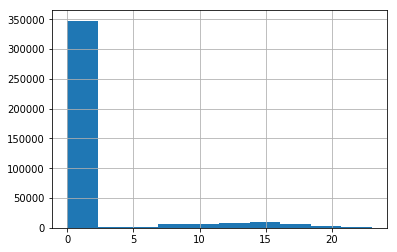

In [10]:
transactions_train['Hour'] = transactions_train['TRDATETIME'].apply(lambda x:
                                           int(datetime.strptime(x, '%d%b%y:%H:%M:%S').strftime('%H'))
                                          )
_ = transactions_train['Hour'].hist()

* Очевидно, что если время транзакции неизвестно, то проставляется *00:00:00*.
Построим распределение по часам, если время транзакции известно.

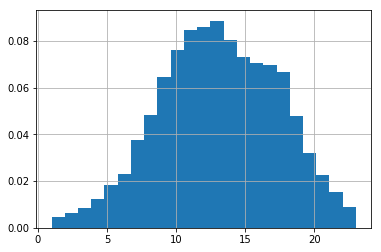

In [11]:
_ = transactions_train[transactions_train['Hour'] != 0]['Hour'].hist(bins = 23, density = True)

* Для выбора временных диапазонов рассчитаем квартили

In [14]:
np.quantile(transactions_train[transactions_train['Hour'] != 0]['Hour'], [.25, .75])

array([10., 17.])

In [15]:
def get_period(hour):
    '''Возвращает временной диапазон, в который попало время time'''
    if hour == 0:
        return 'Not Available'
    elif 1 <= hour < 11:
        return 'From_1_to_10'
    elif 11 <= hour < 18:
        return 'From_11_to_18'
    elif 19 <= hour <= 23:
        return 'From_19_to_23'

* Добавим временной диапазон к датасету

In [16]:
transactions_train['Period'] = transactions_train.Hour.apply(get_period)
transactions_train[transactions_train['Hour'] != 0].head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,MCC_group,Hour,Period
67,01/09/2017,1,6011,NaN,810,24SEP17:19:24:03,45000.0,DEPOSIT,0,0.00,ATM,19,From_19_to_23
92,01/07/2017,1,6011,NaN,810,25JUL17:20:06:04,50000.0,WD_ATM_ROS,0,0.00,ATM,20,From_19_to_23
95,01/09/2017,1,6011,NaN,810,24SEP17:19:22:56,50000.0,DEPOSIT,0,0.00,ATM,19,From_19_to_23
127,01/04/2017,5,6011,NaN,810,06APR17:17:03:05,30000.0,DEPOSIT,1,326211.75,ATM,17,From_11_to_18
139,01/04/2017,5,6011,NaN,810,10APR17:13:02:06,3000.0,WD_ATM_ROS,1,326211.75,ATM,13,From_11_to_18


* Добавим день недели к транзакциям

In [17]:
transactions_train['Weekday'] = transactions_train['TRDATETIME'].apply(lambda x:
                                           datetime.strptime(x, '%d%b%y:%H:%M:%S').strftime('%A')
                                          )
transactions_train.head(10)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,MCC_group,Hour,Period,Weekday
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,0.0,Fastfood,0,Not Available,Monday
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,0.0,Fastfood,0,Not Available,Tuesday
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,0.0,Fastfood,0,Not Available,Monday
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,0.0,Fastfood,0,Not Available,Wednesday
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.0,POS,0,0.0,Supermarket,0,Not Available,Wednesday
10,01/09/2017,1,4111,NaN,978,30SEP17:00:00:00,17.1,POS,0,0.0,Other,0,Not Available,Saturday
11,01/08/2017,1,5814,NaN,810,02AUG17:00:00:00,450.0,POS,0,0.0,Fastfood,0,Not Available,Wednesday
12,01/10/2017,1,5812,NaN,978,01OCT17:00:00:00,21.0,POS,0,0.0,Restaurant,0,Not Available,Sunday
13,01/07/2017,1,5814,NaN,810,31JUL17:00:00:00,720.0,POS,0,0.0,Fastfood,0,Not Available,Monday
14,01/10/2017,1,5814,NaN,810,08OCT17:00:00:00,5988.8,POS,0,0.0,Fastfood,0,Not Available,Sunday


In [19]:
transactions_train.Weekday.value_counts(normalize = True)

Friday       0.160954
Saturday     0.151617
Thursday     0.145250
Wednesday    0.141512
Tuesday      0.140023
Monday       0.134203
Sunday       0.126439
Name: Weekday, dtype: float64

### Анализ типов каналов

* Посчитаем распределение по типам каналов

In [20]:
transactions_train.channel_type.fillna('Not_Available').value_counts(normalize = True)

type1            0.611236
type2            0.353471
type5            0.012149
type4            0.009665
type3            0.006817
Not_Available    0.006662
Name: channel_type, dtype: float64

### Анализ trx-категорий

* Распределение по trx-категориям

In [21]:
transactions_train.trx_category.fillna('Not_Available').value_counts()

POS               334317
DEPOSIT            17285
WD_ATM_ROS         15022
WD_ATM_PARTNER      7695
WD_ATM_OTHER        5583
C2C_IN              5557
C2C_OUT             4395
BACK_TRX            2118
CAT                  962
CASH_ADV              29
Name: trx_category, dtype: int64

### Построим сочетания категорий

**Примечание:** В связи с тем, что количество сочетаний категорий достаточно велико, привожу здесь только наиболее интересные с моей точки зрения категории.

* Время и день недели

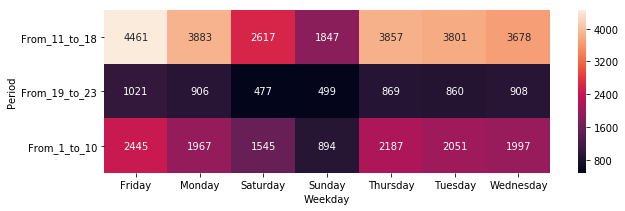

In [22]:
day_month_pivot = transactions_train[transactions_train['Hour'] != 0].pivot_table(index = 'Period',
                                                                                  columns = 'Weekday',
                                                                                  values = 'amount',
                                                                                  aggfunc = 'count',
                                                                                  fill_value = 0)
plt.figure(figsize=(10,3))

_ = sns.heatmap(day_month_pivot, 
                annot=True,
                xticklabels=day_month_pivot.columns.values, 
                yticklabels=day_month_pivot.index.values,          
                fmt="d")

* Видно, что больше всего транзакций совершалось в пятницу с 11:00 до 18:00. Сделаем отдельную категорию "Пятница с 11:00 до 18:00"

In [23]:
transactions_train['WeekTime'] = transactions_train.apply(
    lambda x: 'Friday_from_11_to_18' if x['Period'] == 'From_11_to_18' and x['Weekday'] == 'Friday' else 'Other_time',
    axis = 1
)
transactions_train.WeekTime.value_counts()

Other_time              388502
Friday_from_11_to_18      4461
Name: WeekTime, dtype: int64

* Проверим сочетание trx_category и MCC

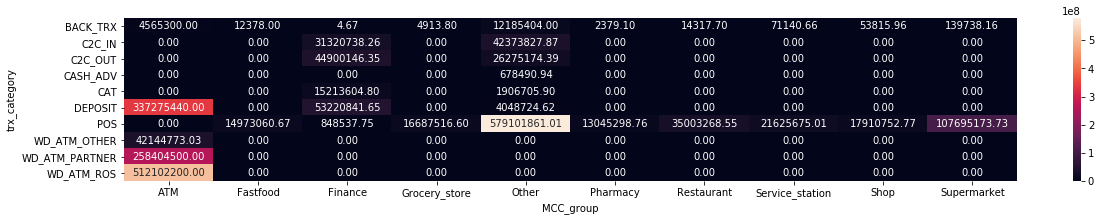

In [25]:
day_month_pivot = transactions_train.pivot_table(index = 'trx_category',
                                                 columns = 'MCC_group',
                                                 values = 'amount',
                                                 aggfunc = 'sum',
                                                 fill_value = 0)
plt.figure(figsize=(20,3))

sns.heatmap(day_month_pivot, 
            annot=True, 
            xticklabels=day_month_pivot.columns.values, 
            yticklabels=day_month_pivot.index.values,
           fmt=".2f")

* Видим несколько категорий, связанных с ATM. Добавим сочетания в датасет.

In [36]:
transactions_train['MCC_trx'] = transactions_train.apply(
    lambda x: x['MCC_group'] + '_' + x['trx_category'] if x['MCC_group'] == 'ATM' else 'Other',
    axis = 1
)
transactions_train.MCC_trx.value_counts()

Other                 349779
ATM_WD_ATM_ROS         15022
ATM_DEPOSIT            14807
ATM_WD_ATM_PARTNER      7695
ATM_WD_ATM_OTHER        5583
ATM_BACK_TRX              77
Name: MCC_trx, dtype: int64

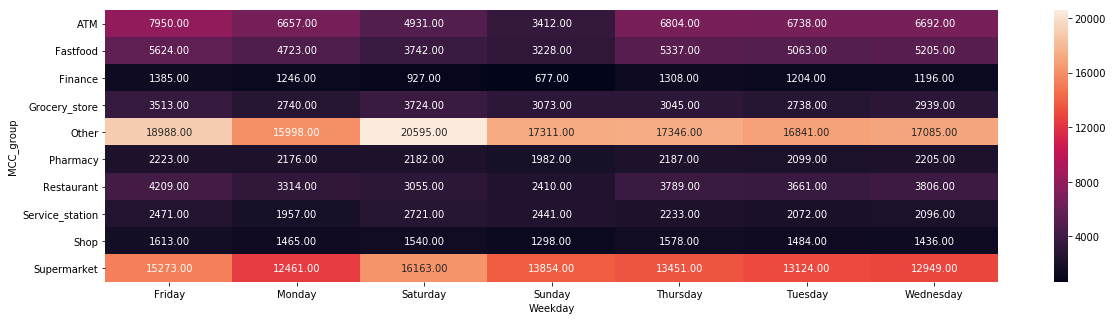

In [34]:
day_month_pivot = transactions_train.pivot_table(index = 'MCC_group',
                                                 columns = 'Weekday',
                                                 values = 'amount',
                                                 aggfunc = 'count',
                                                 fill_value = 0)
plt.figure(figsize=(20, 5))

_ = sns.heatmap(day_month_pivot, 
                annot=True, 
                xticklabels=day_month_pivot.columns.values, 
                yticklabels=day_month_pivot.index.values,
                fmt=".2f")

* Здесь наиболее интересно сочетание количества покупок в супермаркете по дням недели

In [40]:
transactions_train['MCC_Weekday'] = transactions_train.apply(
    lambda x: x['MCC_group'] + '_' + x['Weekday'] if x['MCC_group'] == 'Supermarket' else 'Other',
    axis = 1
)
transactions_train.MCC_Weekday.value_counts(normalize = True)

Other                    0.752458
Supermarket_Saturday     0.041131
Supermarket_Friday       0.038866
Supermarket_Sunday       0.035255
Supermarket_Thursday     0.034230
Supermarket_Tuesday      0.033398
Supermarket_Wednesday    0.032952
Supermarket_Monday       0.031710
Name: MCC_Weekday, dtype: float64

### Составляем итоговый датафрейм

In [41]:
transactions_train.head()

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum,MCC_group,Hour,Period,Weekday,WeekTime,MCC_trx,MCC_Weekday
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.0,POS,0,0.0,Fastfood,0,Not Available,Monday,Other_time,Other,Other
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.0,POS,0,0.0,Fastfood,0,Not Available,Tuesday,Other_time,Other,Other
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.0,POS,0,0.0,Fastfood,0,Not Available,Monday,Other_time,Other,Other
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.0,POS,0,0.0,Fastfood,0,Not Available,Wednesday,Other_time,Other,Other
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.0,POS,0,0.0,Supermarket,0,Not Available,Wednesday,Other_time,Other,Supermarket_Wednesday


In [113]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [174]:
def agg_data(df, col_list, agg_type_list):
    # Делаем общие фичи

    agg_df = df[['cl_id', 'amount']].groupby('cl_id').agg(agg_type_list).reset_index()
    agg_df.columns = agg_df.columns.get_level_values(1)

    old_cols = agg_df.columns
    agg_df.rename(
        columns = {old_col : 'Total_' + old_col if old_col != '' else 'cl_id' for old_col in old_cols}, 
        inplace=True
    )

    
    for col in col_list:
        for agg_type in agg_type_list:
            agg_df = pd.merge(agg_df,
                              get_aggregated_df(df, agg_type, col).reset_index(),
                              on = 'cl_id'
                             )
    return agg_df    

In [176]:
# Создаем тренировочный датасет
train_dataset = agg_data(transactions_train, 
                         ['MCC_group', 'Period', 'Weekday', 'WeekTime', 'MCC_trx', 'MCC_Weekday'], 
                         ['count', 'sum', 'mean', 'median', 'max']
                        )
train_dataset.head()

,cl_id,Total_count,Total_sum,Total_mean,Total_median,Total_max,MCC_group_count_ATM,MCC_group_count_Fastfood,MCC_group_count_Finance,MCC_group_count_Grocery_store,...,MCC_Weekday_median_Supermarket_Tuesday,MCC_Weekday_median_Supermarket_Wednesday,MCC_Weekday_max_Other,MCC_Weekday_max_Supermarket_Friday,MCC_Weekday_max_Supermarket_Monday,MCC_Weekday_max_Supermarket_Saturday,MCC_Weekday_max_Supermarket_Sunday,MCC_Weekday_max_Supermarket_Thursday,MCC_Weekday_max_Supermarket_Tuesday,MCC_Weekday_max_Supermarket_Wednesday
0,1,104,267578.04,2572.865769,300.00,60000.00,3,41,0,2,...,88.00,240.00,60000.00,9575.94,0.00,29.29,0.00,300.00,300.00,598.00
1,5,142,546369.13,3847.669930,1399.02,56164.05,22,1,8,8,...,518.82,663.18,56164.05,6159.89,1953.79,2361.00,1998.64,4056.41,1256.48,663.18
2,9,39,849315.09,21777.310000,100.00,117450.00,7,0,3,0,...,39.00,0.00,117450.00,0.00,0.00,0.00,0.00,0.00,39.00,0.00
3,10,463,1124343.99,2428.388747,325.00,150000.00,66,4,4,30,...,187.95,449.55,150000.00,3979.98,940.00,2443.34,6932.46,951.68,1449.32,1999.00
4,11,217,427747.14,1971.184977,297.00,60000.00,10,31,0,6,...,452.00,174.00,60000.00,2993.00,951.00,1301.00,1173.00,1210.00,1857.00,1230.00


In [177]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3999 entries, 0 to 3998
Columns: 191 entries, cl_id to MCC_Weekday_max_Supermarket_Wednesday
dtypes: float64(152), int64(39)
memory usage: 5.9 MB
